# Exploratory Data Analysis of Images

Image quality factors such as resolution, the presence of noise and artifacts, contrast, and size affect the visual information contained in mammography, and crucially determine the performance of deep learning classification models.

In this section, we conduct an exploratory data analysis of the CBIS-DDSM full mammogram imaging data with several objectives in mind:

1. Evaluate image quality in terms of noise, annotations, artifacts, and labeling that may negatively affect the classification task.
2. Inspect the distribution of image resolution and aspect ratios.
3. Examine pixel intensity distributions by class.
4. Visually characterize image texture and contrast vis-a-vis case pathology, abnormality type, and morphology.

This analysis is organized as follows:

1. Overview: Describes how benign and malignant images are organized in the training and test sets.
2. Resolution and Aspect Ratio: Analyze resolution and aspect ratios
3. Pixel Value Distribution: Evaluate the distribution of pixel values between benign and malignant cases
4. Image Quality Analysis: Visualize and assess image quality with respect to text, labels, and artifacts
5. Calcification Case Analysis: Examine calcification case images for the various morphologies
6. Mass Case Analysis: Review mass case images of various shapes and margins.
7. Summary and Key Takeaways: Review key observations and takeaways.

In [1]:
import os
if 'jbook' in os.getcwd():
    os.chdir(os.path.abspath(os.path.join("../../..")))
import warnings
import numpy as np
from myst_nb import glue
from bcd.explore.image.eda_image import ImageExplorer
warnings.filterwarnings("ignore")

## Overview

There are 3565 full mammogram images, not counting one for which the DICOM file was corrupt. {numref}`edai_stats_fig` shows the number of images in the training and test sets by pathology.

,Benign,% Benign,Malignant,% Malignant,Total,Split
Dataset,,,,,,
train,1680,59,1181,41,2861,0.80
test,428,61,276,39,704,0.20


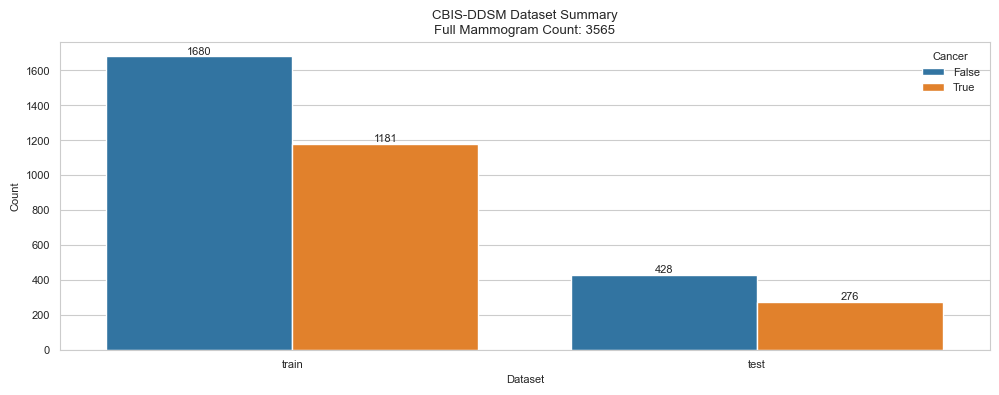

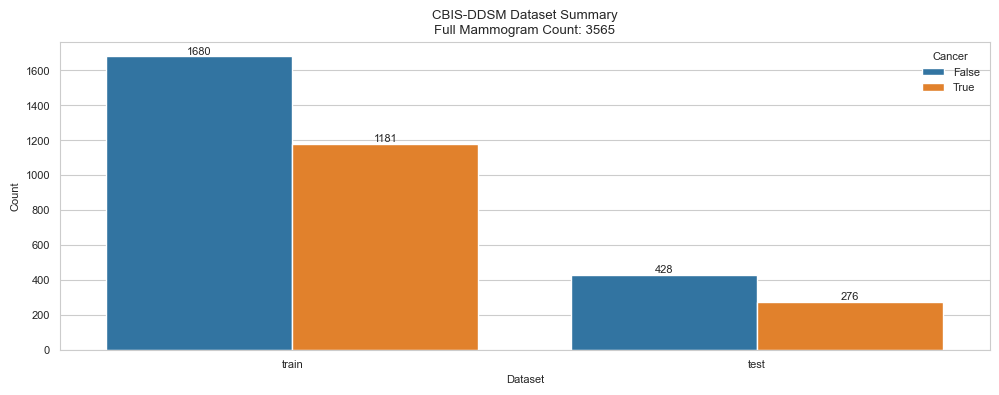

In [2]:
x = ImageExplorer()
fig, stats = x.summary()
glue("edai_stats_df", stats)
glue("edai_stats_plot", fig)

```{glue:figure} edai_stats_plot
---
align: center
name: edai_stats_plot_fig
---
Overview of CBIS-DDSM Training and Test Sets
```

```{glue:figure} edai_stats_df
---
align: center
name: edai_stats_df_fig
---
CBIS-DDSM Training and Test Set Statistics
```



As shown in {numref}`edai_stats_plot_fig` and {numref}`edai_stats_df_fig`, we have a training test split of 80/20 where malignancy was found in approximately 40% of the cases.

Class imbalance can lead to biased predictions. Augmenting the malignant class with various transformations will mitigate bias introduced by class imbalance.

## Resolution and Aspect Ratio

Optimal resolution is essential to distinguish malignancy in subtle radiological masses and calcifications. {numref}`edai_resolution_fig` illuminates the distribution of resolution in the CBIS-DDSM dataset.

In [3]:
fig, stats = x.analyze_resolution()

glue("edai_resolutions_df)
glue("edai_resolutions_plot", fig)

SyntaxError: unterminated string literal (detected at line 3) (1650016877.py, line 3)

```{glue:figure} edai_resolutions_plot
---
align: center
name: edai_resolutions_plot_fig
---
Analysis of Image Resolution and Aspect Ratio
```

```{glue:figure} edai_resolutions_df
---
align: center
name: edai_resolutions_df_fig
---
Descriptive Statistics for Resolution and Aspect Ratio
```

{numref}`edai_resolutions_plot_fig` and {numref}`edai_resolutions_df_fig` indicate high-resolution images with heights ranging from 3256 to 7111 pixels and widths of 1531 to 5431 pixels. The mean aspect ratio is 0.6 and ranges from 0.3 to 0.83.

Images will be resized to 256x256 for the convolutional neural network model. Generally, there are two approaches to resizing:

- **Destructive Resizing**: The image is resized without retaining the original aspect ratio.
- **Non-Destructive Resizing**: Images are resized with padding to retain the original aspect ratio.

We will be experimenting with both methods to determine which results in higher classification accuracy, and recall.

## Pixel Value Distribution

Pixel intensity value is the property that defines the spatial characteristics of the breast and abnormalities in mammography. Here, we examine the centrality and variation (standard deviation) of pixel values for benign and malignant cases.

In [ ]:
_, stats = x.analyze_pixel_values()
glue("edai_pixels_df)
glue("edai_pixels_plot", fig)

```{glue:figure} edai_pixels_plot
---
align: center
name: edai_pixels_plot_fig
---
Analysis of Image Pixel Intensity Statistics
```

```{glue:figure} edai_pixels_df
---
align: center
name: edai_pixels_df_fig
---
Descriptive Statistics for Average Image Pixel Intensity
```

Several observations can be made based upon {numref}`edai_pixels_plot_fig` and {numref}`edai_pixels_df_fig`:

1. Standard deviation and mean appear to be positively and linearly associated.
2. Though from a statistical perspective, outliers are extant at 3 * the standard deviation from the average mean, the maximum values are approximately half of the maximum pixel value for 16-bit images.
3. Malignant cases tend to have slightly higher averages and greater variation in pixel intensities.

Is the difference in average mean pixel intensities between classes significant?

In [ ]:
# Create a lambda expression to filter the data
cond_benign = lambda x: x['cancer'] == False
cond_malignant = lambda x: x['cancer'] == True

# Obtain the mean_pixel_values for each pathology
benign_pixels_averages = x.get_data(x='mean_pixel_value', condition=cond_benign)
malignant_pixels_averages = x.get_data(x='mean_pixel_value', condition=cond_malignant)

benign_mean = np.mean(benign_pixels_averages)
benign_std = np.std(benign_pixels_averages)
malignant_mean = np.mean(malignant_pixels_averages)
malignant_std = np.std(malignant_pixels_averages)

# Conduct a Student's T-Test
t, pvalue = x.test_centrality(a=benign_pixels_averages, b=malignant_pixels_averages, alternative='less')
df = len(benign_pixels_averages) + len(malignant_pixels_averages) - 2

glue("benign_mean", benign_mean)
glue("benign_std", benign_std)
glue("malignant_mean", malignant_mean)
glue("malignant_std", malignant_std)
glue("t_statistic", t)
glue("pvalue", pvalue)
glue("degrees_of_freedom", df)

A student's t-test reveals that the average mean intensity values for the benign cases (M={glue:}`benign_mean`, SD={glue:}`benign_std`) were less than average mean pixel values for the malignant cases (M={glue:}`malignant_mean`, SD={glue:}`malignant_std`); t({glue:}`degrees_of_freedom`)={glue:}`t_statistic`, p < 0.01.

We've analyzed pixel values at the aggregate level, let's examine the pixel intensity distributions for a sampling of the images.

In [ ]:
title = f"CBIS-DDSM\nPixel Intensity Histograms"
fig = x.visualize(n=20, sort_by='cancer', histogram=True, title=title, random_state=5)

glue("edai_histograms", fig)

```{glue:figure} edai_histograms
---
align: center
name: edai_histograms_fig
---
Pixel Intensity Histograms for Sample Mammograms
```

We've converted the 16-bit images to 8-bit unsigned grauyscale format so that the pixel values would be normalized between 0 and 255.

{numref}`edai_histograms_fig` shows histograms dominated by a single peak near the black end of the spectrum, with barely discernable weaker peaks at various points within

## Image Quality Analysis

Here, we examine the quality of the mammography in terms of artifacts, text, and other anomalies that may influence the classification task.

In [ ]:
fig = x.visualize(n=50, sort_by='cancer', random_state=5)
glue("edai_dqa", fig)

```{glue:figure} edai_dqa
---
align: center
name: edai_dqa_fig
---
Pixel Intensity Histograms for Sample Mammograms
```

{numref}`edai_dqa_fig` shows a random sampling of 50 mammogram images from the CBIS-DDSM. We make note of the following:

1. Artifacts and/or lines were found in 44 out of 50 (88%) images.
2. Pectoral muscle, evident in 19 (38%) of the images in the sample, has similar density and pixel intensity values as the dense tissues of interest. Image preprocessing must identify and remove both artifacts and pectoral muscles from the images.
3. The first three rows contain mammograms showing benign diagnoses and the last two rows show malignancies. Generally, malignancies are characterized by high density and high contrast in the regions of interest.
4. Contrast enhancement must be incorporated into the preprocessing workflow to ensure that more subtle features can be distinguished by the network.

## Calcification Case Analysis

A calcification is a calcium deposit that develops in the breast. They usually appear as white, opaque markings on mammograms. Diagnosing breast calcifications involves analyzing the morphology and distribution of calcifications. Here, we examine the most common calcification morphologies and distributions in the CBIS-DDSM dataset.

### Calcification Morphology

Morphology defines the form of calcifications.  It is the most important factor in differentiating between benign and malignant calcifications. Here, we examine the most common calcification morphologies {numref}`calcification_morphologies` in the CBIS-DDSM dataset.

```{table} Calcification Morphologies
:name: calcification_morphologies

| Morphology            | BI-RADS   Assessment                                   |
|-----------------------|--------------------------------------------------------|
| Lucent Centered       | BI-RADS 2 - Benign                                     |
| Punctate              | BI-RADS 2,3,4 - Benign / Probably   Benign / Suspicious |
| Pleomorphic           | BI-RADS 4 - Suspicious                                  |
| Amorphous             | BI-RADS 4 - Suspicious                                  |
| Fine Linear Branching | BI-RADS 4C - Highly Suspicious                         |
```

#### Lucent-Centered

Lucent-Centered calcifications are round or oval, ranging from 1mm to over a centimeter. They are the result of fat necrosis, calcified debris in ducts, and occasional fibroadenomas. Lucent-centered calcifications are assessed as BI-RADS 2 – Benign {cite}`smithuisRadiologyAssistantDifferential`.

In [ ]:
title = f"CBIS-DDSM\nCalcification Cases - Lucent Centered Calcification Type"
cond = lambda x: x['calc_type'].isin(['LUCENT_CENTERED', 'LUCENT_CENTERED_PUNCTATE'])
fig = x.visualize(n=20, condition=cond, sort_by=['cancer'], title=title, random_state=20)
glue("edai_lucent", fig)

```{glue:figure} edai_lucent
---
align: center
name: edai_lucent_fig
---
Calcification Cases Lucent-Centered Calcification Type
```

{numref}`edai_lucent_fig` displays sample calcification cases with lucent-centered calcifications.

#### Punctate

Punctate morphology refers to round calcifications smaller than 0.5mm that frequently form in the acini of the terminal duct lobular unit. Round and punctate calcifications are classified as:

- BI-RADS 2: when scattered round calcifications
- BI-RADS 3 or 4: when in an isolated cluster

In [ ]:
title = f"CBIS-DDSM\nCalcification Cases - Punctate Calcification Type"
cond = lambda x: x['calc_type'] == 'PUNCTATE'
fig = x.visualize(n=20, condition=cond, sort_by=['cancer'], title=title, random_state=20)
glue("edai_punctate", fig)

```{glue:figure} edai_punctate
---
align: center
name: edai_punctate_fig
---
Calcification Cases Punctate Calcification Type
```

{numref}`edai_punctate_fig` shows calcification cases with punctate calcifications.

#### Pleomorphic

Pleomorphic calcifications vary in size and shape but are usually smaller than 0.5 mm in diameter. They represent a 25%-40% chance of malignancy.

In [ ]:
title = f"CBIS-DDSM\nCalcification Cases - Pleomorphic Calcification Type"
cond = lambda x: x['calc_type'] == 'PLEOMORPHIC'
fig = x.visualize(n=20, condition=cond, sort_by=['cancer'], title=title, random_state=20)
glue("edai_pleomorphic", fig)

```{glue:figure} edai_pleomorphic
---
align: center
name: edai_pleomorphic_fig
---
Calcification Cases Pleomorphic Calcification Type
```

{numref}`edai_pleomorphic_fig` shows calcification cases with pleomorphic calcifications.

#### Amorphous

Amorphous calcifications are defined as ‘without clearly defined shape or form’. They are typically small and/or hazy in appearance. The majority of cases are benign (60%), with the remainder of cases presenting as high-risk (20%) or malignant (20%) {cite}`smithuisRadiologyAssistantDifferential`.

In [ ]:
title = f"CBIS-DDSM\nCalcification Cases - Amorphous"
cond = lambda x: x['calc_type'] == 'AMORPHOUS'
fig = x.visualize(n=20, condition=cond, sort_by=['cancer'], title=title, random_state=20)
glue("edai_amorphous", fig)

```{glue:figure} edai_amorphous
---
align: center
name: edai_amorphous_fig
---
Calcification Cases Amorphous Calcification Type
```

{numref}`edai_amorphous_fig` shows calcification cases with amorphous calcifications.

#### Fine Linear Branching

These are thin, irregular, linear, or curvilinear calcifications and are highly suspicious (BI-RADS-4C).

In [ ]:
title = f"CBIS-DDSM\nCalcification Cases - Fine Linear Branching"
cond = lambda x: x['calc_type'] == 'FINE_LINEAR_BRANCHING'
fig = x.visualize(n=20, condition=cond, sort_by=['cancer'], title=title, random_state=20)
glue("edai_flb", fig)

```{glue:figure} edai_flb
---
align: center
name: edai_flb_fig
---
Calcification Cases Fine Linear Branching Calcification Type
```

{numref}`edai_flb_fig` shows calcification cases with fine linear branching calcifications.

### Calcification Distribution

Calcification Distribution can be described as how an abnormality spatially presents within the breast tissue. We will be analyzing the following five calcification distributions in {numref}`calcification_distributions`.

```{table} Calcification Distributions
:name: calcification_distributions
| Distribution        | BI-RADS Assessment                                    |
|---------------------|-------------------------------------------------------|
| Clustered           | BI-RADS - 2,3,4 - Benign/Probably Benign / Suspicious |
| Linear | BI-RADS - 2,3,4 - Benign/Probably Benign / Suspicious |
| Diffusely Scattered | BI-RADS 2 - Benign                                    |
| Regional            | BI-RADS 3 - Probably Benign                           |
| Segmental           | BI-RADS 4,5 - Suspicious / Highly Suspicious          |
```

#### Clustered

Clustered distribution describes at least 5 calcifications that occupy a small volume of tissue.  These calcifications are seen in benign and malignant pathologies and are of intermediate concern. Clusters that are scattered throughout the breast indicate in favor of a benign entity; whereas, a single cluster is highly suggestive of malignancy.

In [ ]:
title = f"CBIS-DDSM\nCalcification Cases - Clustered"
cond = lambda x: x['calc_distribution'] == 'CLUSTERED'
fig = x.visualize(n=20, condition=cond, sort_by=['cancer'], title=title, random_state=20)
glue("edai_clustered", fig)

```{glue:figure} edai_clustered
---
align: center
name: edai_clustered_fig
---
Calcification Cases Clustered Calcification Distribution
```

{numref}`edai_clustered_fig` shows calcification cases with clustered calcifications.

#### Linear

Linear calcifications, as the name suggests, appear in a linear fashion in the breast. This distribution can indicate benign, probably benign, or suspicious. Benign linear calcifications include vascular calcifications, one of the most common findings encountered in mammography. Linear branching calcifications that follow a ductal distribution are associated with ductal carcinoma in situ (DCIS) and invasive ductal carcinoma and are highly suspicious. They have a more delicate appearance and show a finer more interrupted dot-dash pattern {cite}`laiLinearBreastCalcifications2012`.

In [ ]:
title = f"CBIS-DDSM\nCalcification Cases - Linear"
cond = lambda x: x['calc_distribution'] == 'LINEAR'
fig = x.visualize(n=20, condition=cond, sort_by=['cancer'], title=title, random_state=20)
glue("edai_linear", fig)

```{glue:figure} edai_linear
---
align: center
name: edai_linear_fig
---
Calcification Cases Linear Calcification Distribution
```

{numref}`edai_linear_fig` shows calcification cases with linear calcifications.

#### Diffusely Scattered

Diffuse scattered calcifications appear as calcifications or clusters of calcifications throughout the breast. These are typically diagnosed as benign.

In [ ]:
title = f"CBIS-DDSM\nCalcification Cases - Diffusely Scattered"
cond = lambda x: x['calc_distribution'] == 'DIFFUSELY_SCATTERED'
fig = x.visualize(n=20, condition=cond, sort_by=['cancer'], title=title, random_state=20)
glue("edai_ds", fig)

```{glue:figure} edai_ds
---
align: center
name: edai_ds_fig
---
Calcification Cases Diffusely Scattered Calcification Distribution
```

#### Regional

Regional calcifications are scattered in a large volume (>2 cc) of breast tissue and are typically seen as benign.

In [ ]:
title = f"CBIS-DDSM\nCalcification Cases - Regional"
cond = lambda x: x['calc_distribution'] == 'REGIONAL'
fig = x.visualize(n=20, condition=cond, sort_by=['cancer'], title=title, random_state=20)
glue("edai_regional", fig)

```{glue:figure} edai_regional
---
align: center
name: edai_regional_fig
---
Calcification Cases Regional Calcification Distribution
```

{numref}`edai_regional_fig` shows calcification cases with regional calcifications.

#### Segmental

Segmental calcifications are calcium deposits that follow the expected distribution of one or more ducts and their branches. They can have a branching appearance or cover a triangular region, with the most acute angle pointing to the nipple. Whereas segmental calcifications often can be characterized as benign, microcalcifications following a segmental distribution are often suspicious for malignancy because of their anatomic relationship with the ductal system {cite}`chenSegmentalBreastCalcifications2012`.

In [ ]:
title = f"CBIS-DDSM\nCalcification Cases - Segmental"
cond = lambda x: x['calc_distribution'] == 'SEGMENTAL'
fig = x.visualize(n=20, condition=cond, sort_by=['cancer'], title=title, random_state=20)
glue("edai_segmental", fig)

```{glue:figure} edai_segmental
---
align: center
name: edai_segmental_fig
---
Calcification Cases Segmental Calcification Distribution
```

{numref}`edai_segmental_fig` shows calcification cases with segmental calcifications.

This concludes our analysis of calcification cases. Next we examine mass cases and their shapes and margins.

## Mass Case Analysis

Breast masses, usually non-cancerous, are three-dimensional, space-occupying lesions found in the breast in two different mammograms. The BI-RADS {cite}`americancollegeofradiologyACRBIRADSAtlas2013` lexicon describes masses in terms of their shape and margin. In this section, we visually examine the mass cases in terms of their shape and margin characteristics.

### Mass Shape Analysis

Masses can present in a variety of shapes, the most common are listed in  {numref}`mass_shapes`:

```{table} Mass Shapes
:name: mass_shapes
| Shape     | BI-RADS Assessment           |
|-----------|------------------------------|
| Round     | BI-RADS 3 - Probably Benign  |
| Oval      | BI-RADS 3 - Probably Benign  |
| Lobulated | BI-RADS 3 - Probably Benign  |
| Irregular | BI-RADS 5 - Highly Suspicious |
```

#### Round Masses

A round mass is spherical, ball-shaped, or circular. Though a well-demarcated cancer may be round, round masses are usually non-cancerous.

In [ ]:
title = f"CBIS-DDSM\nMass Cases - Round"
cond = lambda x: x['mass_shape'] == 'ROUND'
fig = x.visualize(n=20, condition=cond, sort_by=['cancer'], title=title, random_state=20)
glue("edai_round", fig)

```{glue:figure} edai_round
---
align: center
name: edai_round_fig
---
Mass Cases Round Mass Shape
```

{numref}`edai_round_fig` shows round mass cases.

#### Oval Masses

An oval mass is elliptical or egg-shaped and is usually suggestive of a benign lesion.

In [ ]:
title = f"CBIS-DDSM\nMass Cases - Oval"
cond = lambda x: x['mass_shape'] == 'OVAL'
fig = x.visualize(n=20, condition=cond, sort_by=['cancer'], title=title, random_state=20)

#### Lobulated Masses

A lobulated mass has an undulating or scalloped contour and is usually suggestive of a benign lesion.

In [ ]:
title = f"CBIS-DDSM\nMass Cases - Lobulated"
cond = lambda x: x['mass_shape'] == 'LOBULATED'
fig = x.visualize(n=20, condition=cond, sort_by=['cancer'], title=title, random_state=20)
glue("edai_oval", fig)

```{glue:figure} edai_oval
---
align: center
name: edai_oval_fig
---
Mass Cases Oval Mass Shape
```

{numref}`edai_oval_fig` shows oval mass cases.

#### Irregular

An irregular mass is uneven in shape and cannot be characterized as round, oval, or lobulated {cite}`americancollegeofradiologyACRBIRADSAtlas2013`.

In [ ]:
title = f"CBIS-DDSM\nMass Cases - Irregular"
cond = lambda x: x['mass_shape'] == 'IRREGULAR'
fig = x.visualize(n=20, condition=cond, sort_by=['cancer'], title=title, random_state=20)
glue("edai_irregular", fig)

```{glue:figure} edai_irregular
---
align: center
name: edai_irregular_fig
---
Mass Cases Irregular Mass Shape
```

{numref}`edai_irregular_fig` shows masses with irregular shapes.

### Mass Margin Analysis

The mass margin is the edge or border of the lesion and indicates a demarcation from the adjacent normal breast parenchyma. Mass margin is an important predictor of whether a mass is benign or malignant.

Our visualization analysis will include the following five mass margins defined in the standard BI-RADS terminology.

```{table} Mass Margins
:name: mass_margins
| Margin         | BI-RADS Assessment            |
|----------------|-------------------------------|
| Circumscribed  | BI-RADS 3 - Probably Benign   |
| Ill-Defined    | BI-RADS 4 - Suspicious        |
| Microlobulated | BI-RADS 4 - Suspicious        |
| Spiculated     | BI-RADS 5 - Highly Suspicious |
| Obscured       | N/A                           |
```

#### Circumscribed

A circumscribed margin is sharply demarcated with an abrupt transition between the lesion and the surrounding tissue. At least 75% of the margin must be well-defined for a mass to qualify as circumscribed. A circumscribed margin is most likely a feature of a probably benign lesion.

In [ ]:
title = f"CBIS-DDSM\nMass Cases - Circumscribed"
cond = lambda x: x['mass_margins'] == 'CIRCUMSCRIBED'
fig = x.visualize(n=20, condition=cond, sort_by=['cancer'], title=title, random_state=20)

#### Ill-Defined

Ill-defined or indistinct margins have no clear demarcation of the entire margin, or any portion of the margin, from the surrounding tissue.  An ill-defined margin is usually assessed as suspicious.

In [ ]:
title = f"CBIS-DDSM\nMass Cases - Ill-Defined"
cond = lambda x: x['mass_margins'] == 'ILL_DEFINED'
fig = x.visualize(n=20, condition=cond, sort_by=['cancer'], title=title, random_state=20)
glue("edai_ill-defined", fig)

```{glue:figure} edai_ill-defined
---
align: center
name: edai_ill-defined_fig
---
Mass Cases Ill-Defined Mass Margin
```

{numref}`edai_ill-defined_fig` shows masses with ill-defined margins.

#### Microlobulated

Microlobulated masses have undulating, lobulated margins and measure only several millimeters or smaller. They are suspicious of malignancy and suspicion increases with the number of lobulations.

In [ ]:
title = f"CBIS-DDSM\nMass Cases - Microlobulated"
cond = lambda x: x['mass_margins'] == 'MICROLOBULATED'
fig = x.visualize(n=20, condition=cond, sort_by=['cancer'], title=title, random_state=20)
glue("edai_microlobulated", fig)

```{glue:figure} edai_microlobulated
---
align: center
name: edai_microlobulated_fig
---
Mass Cases Microlobulated Mass Margin
```

{numref}`edai_microlobulated_fig` shows masses with microlobulated margins.

#### Spiculated

A spiculated margin is dense, irregular, and characterized by lines of varying lengths and thickness radiating from the margins of the mass. They are considered virtually pathognomonic of breast cancer because very few benign lesions produce such an appearance.

In low-density breasts, spiculated masses can be easily visible; however, they become less conspicuous with increasing breast density.

In [ ]:
title = f"CBIS-DDSM\nMass Cases - Spiculated"
cond = lambda x: x['mass_margins'] == 'SPICULATED'
fig = x.visualize(n=20, condition=cond, sort_by=['cancer'], title=title, random_state=20)
glue("edai_spiculated", fig)

```{glue:figure} edai_spiculated
---
align: center
name: edai_spiculated_fig
---
Mass Cases Spiculated Mass Margin
```

{numref}`edai_spiculated_fig` shows masses with spiculated margins.

#### Obscured

An obscured margin is greater than 25% hidden by superimposed or adjacent fibroglandular tissue. Further imaging may be required in such cases, to render an assessment.

In [ ]:
title = f"CBIS-DDSM\nMass Cases - Obscured"
cond = lambda x: x['mass_margins'] == 'OBSCURED'
fig = x.visualize(n=20, condition=cond, sort_by=['cancer'], title=title, random_state=20)
glue("edai_obscured", fig)

```{glue:figure} edai_obscured
---
align: center
name: edai_obscured_fig
---
Mass Cases Obscured Mass Margin
```

{numref}`edai_obscured_fig` shows masses with obscured margins.

## Summary and Key Takeaways

The purpose of this section was to conduct an exploratory data analysis of the CBIS-DDSM full mammogram imaging data. We evaluated image quality in terms of annotations, artifacts, and labeling in the dataset, inspected image resolutions, analyzed the distribution of pixel intensities vis-a-vis pathology, and visually characterized image texture and contrast for masses and calcifications.

From this analysis, several key takeaways emerged:

1. Of the 3565 cases, approximately 40% of the training and test cases are malignant. Class imbalance can lead to biased predictions and degraded classification performance. Image augmentation techniques should be employed to mitigate bias introduced by class imbalance.
2. Approximately 88% of the samples we examined had labeling, lines, and artifacts that must be removed during image preprocessing.
3. Pectoral muscle, found in approximately 38% of the images sampled, shares some of the same visual characteristics of the dense region of interest and may compromise the classification performance of the convolutional neural network. Pectoral muscle removal will be an essential tasks in the image preprocessing workflow.
4. An analysis of pixel intensities revealed that the average pixel values for malignant cases (M=14,025.57, SD=4620.74) was greater than that of the benign cases (M=12,762.52, SD=4,436.66). A student's t-test indicated the statistical significance (t(3563)=-8.15, p < 0.01) of this result.
5. The CBIS-DDSM is comprised of high-resolution 16-bit images with aspect ratios ranging from 0.3 to 0.83. These images will be downsized to 256 x 256 pixels. Experimentation will determine whether to perform destructive resizing that changes the aspect ratio, or padded resizing in which the original aspect ratio is retained.
6. Contrast enhancement must be encorporated into the preprocessing workflow to ensure that subtle masses and calcifications can be effectively distinguished from surrounding breast tissue as benign or malignant.

This concludes the exploratory data analysis of the CBIS-DDSM dataset. In this next section, we will build a modularized preprocessing module for denoising, artifact and pectoral removal,  contrast enhancement, and resizing.